# Time-Series Forecasting – Stock Prices
### **Author:** Saima Chowdhury
**Email:** saima.chowdhury811@gmail.com

---
**Date:** 2025-10-03  
**Dataset:** Kaggle — https://www.kaggle.com/code/avikumart/timeseries-stock-price-analysis-forecasting/input


**Project (Github):** https://github.com/SaimaChowdhury/Time-Series-Forecasting-Stock-Prices-prediction.git  


### ***Importing Libraries***

In [33]:
import pandas as pd
import numpy as np


import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from statsmodels.tsa.arima.model import ARIMA # Import ARIMA model
from prophet import Prophet # Import Prophet model

from sklearn.preprocessing import StandardScaler # Import StandardScaler__ scaling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


### ***Reading Dataset***

In [5]:
df = pd.read_csv('/content/all_stocks_5yr.csv' , encoding='latin-1')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## Data Preprocessing
---
**⏺ Handling missing values**



In [6]:
# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

#df.ffill(inplace=True)
print("-" * 30)

# Verify that there are no remaining missing values
print("\nMissing values after handling:")
print(df.isnull().sum())

Missing values before handling:
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
------------------------------

Missing values after handling:
date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64


**⏺ Converting date column**


In [7]:
# Convert the 'date' column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index of the DataFrame
df.set_index('date', inplace=True)

# Display the head of the DataFrame and the index to verify the changes
display(df.head())
print("\n" + "-" * 70)
display(df.index)

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL



----------------------------------------------------------------------


DatetimeIndex(['2013-02-08', '2013-02-11', '2013-02-12', '2013-02-13',
               '2013-02-14', '2013-02-15', '2013-02-19', '2013-02-20',
               '2013-02-21', '2013-02-22',
               ...
               '2018-01-25', '2018-01-26', '2018-01-29', '2018-01-30',
               '2018-01-31', '2018-02-01', '2018-02-02', '2018-02-05',
               '2018-02-06', '2018-02-07'],
              dtype='datetime64[ns]', name='date', length=619040, freq=None)

### Feature engineering:
Create new features that might be useful for time series analysis, such as lag features or moving averages.


In [8]:
df['close_lag_1'] = df.groupby('Name')['close'].shift(1)
df['moving_average_50'] = df.groupby('Name')['close'].transform(lambda x: x.rolling(window=50).mean())
display(df.head())

,open,high,low,close,volume,Name,close_lag_1,moving_average_50
date,,,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,NaN,NaN
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,14.75,NaN
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,14.46,NaN
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,14.27,NaN
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,14.66,NaN


### Scaling:
Scale numerical features if necessary, depending on the model to be used. Identify numerical columns, handle remaining missing values, and apply a scaler to the selected columns.


In [31]:
# Identify numerical columns to scale
# Exclude the 'Name' column as it's categorical.
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Handle remaining missing values by dropping rows with NaNs in the numerical columns
# This is necessary because the first values per group for lag and rolling mean are NaNs
df.dropna(subset=numerical_cols, inplace=True)

# Verify that there are no remaining missing values in these columns
print("Missing values after dropping NaNs:")
print(df[numerical_cols].isnull().sum())

# Re-apply the scaler to the selected numerical columns on the cleaned data
# Instantiate the scaler again for clarity after dropping rows
scaler = StandardScaler()

# Fit and transform the data again after dropping rows
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("\n" + "-" * 100)

# Display the head of the DataFrame with scaled features
display(df.head())

Missing values after dropping NaNs:
open                 0
high                 0
low                  0
close                0
volume               0
close_lag_1          0
moving_average_50    0
dtype: int64

----------------------------------------------------------------------------------------------------


,open,high,low,close,volume,Name,close_lag_1,moving_average_50
date,,,,,,,,
2013-04-22,-0.689844,-0.691610,-0.693131,-0.694733,0.575422,AAL,-0.689746,-0.699934
2013-04-23,-0.696537,-0.686682,-0.694871,-0.686823,0.934256,AAL,-0.694820,-0.699613
2013-04-24,-0.687105,-0.686581,-0.688014,-0.685302,0.212213,AAL,-0.686904,-0.699202
2013-04-25,-0.684164,-0.684268,-0.686070,-0.687634,0.146216,AAL,-0.685382,-0.698798
2013-04-26,-0.685888,-0.684268,-0.686377,-0.683882,0.347301,AAL,-0.687716,-0.698399


### Split data:
Split the data into training and testing sets. Define features and target, then split the data into training and testing sets while preserving the time series order. Finally, print the shapes to verify the split.


In [10]:
# Define the target variable y as the 'close' column
y = df['close']

# Define the features X as all other columns in the DataFrame df
X = df.drop('close', axis=1)

# Split the data into training and testing sets
# Use a test size of 20% and set shuffle=False to maintain the time series order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shapes of the training and testing sets to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (475434, 7)
Shape of X_test: (118859, 7)
Shape of y_train: (475434,)
Shape of y_test: (118859,)


## Implement Arima model
---
**Train and evaluate an ARIMA model on the time series data:**


In [32]:
# Define the order of the ARIMA model (p, d, q).
# These parameters need to be chosen based on analysis of the time series data (e.g., ACF and PACF plots).
# For simplicity, a fixed order (5, 1, 0) is used here as an example.
order = (5, 1, 0)

# Initialize an empty list to store ARIMA predictions for the test set.
arima_predictions = []

# To handle warnings about the date index, ensure it's monotonic and has a frequency.
# First, sort the index to make it monotonic.
y_train_sorted = y_train.sort_index()

# Attempt to infer the frequency of the sorted index.
# If the frequency cannot be inferred (e.g., irregular time series), the warning might persist,
# or a different approach like resampling might be needed.
try:
    y_train_sorted = y_train_sorted.asfreq(pd.infer_freq(y_train_sorted.index))
except ValueError:
    print("Could not infer frequency. Proceeding without frequency information.")
    pass # Proceed without frequency if inference fails

# Fit the ARIMA model to the training data (y_train_sorted).
# The 'enforce_stationarity' and 'enforce_invertibility' are set to False to avoid issues during fitting.
arima_model_fit = ARIMA(y_train_sorted, order=order).fit()

# Forecast values for the length of the test set.
# The 'steps' parameter specifies the number of future periods to forecast.
# Note: Forecasting with an index that has no frequency or is not monotonic can be problematic.
# The sorting and frequency inference above aim to mitigate this.
arima_predictions = arima_model_fit.forecast(steps=len(y_test))


# Evaluate the ARIMA model's performance on the test set (y_test) using the generated predictions.

# Align the index of arima_predictions with y_test for correct evaluation.
# This is important if the ARIMA model's forecast index is not automatically aligned.
arima_predictions.index = y_test.index


# Calculate Mean Squared Error (MSE).
# MSE measures the average squared difference between the actual and predicted values.
mse = mean_squared_error(y_test, arima_predictions)

# Calculate Root Mean Squared Error (RMSE).
# RMSE is the square root of MSE and provides an error metric in the same units as the target variable.
rmse = np.sqrt(mse)

# Calculate Mean Absolute Percentage Error (MAPE).
# MAPE measures the average absolute percentage difference between actual and predicted values.
# It's useful for understanding the forecast accuracy in relative terms.
# Avoid division by zero in MAPE calculation if actual values are zero.
mape = np.mean(np.abs((y_test - arima_predictions) / y_test)) * 100
# Using sklearn's mean_absolute_percentage_error is generally safer as it handles zero values.

mape = mean_absolute_percentage_error(y_test, arima_predictions) * 100 # Multiply by 100 for percentage


# Print a summary of the fitted ARIMA model.
print("\nARIMA Model Summary:")
print(arima_model_fit.summary())


# Print the evaluation metrics for the ARIMA model.
print("\n\nARIMA Model Evaluation:")
print("-" * 30)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")

Could not infer frequency. Proceeding without frequency information.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:               475434
Model:                 ARIMA(5, 1, 0)   Log Likelihood            -2934082.362
Date:                Sat, 04 Oct 2025   AIC                        5868176.724
Time:                        06:38:46   BIC                        5868243.156
Sample:                             0   HQIC                       5868195.569
                             - 475434                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8325      0.001   -978.245      0.000      -0.834      -0.831
ar.L2         -0.6671      0.001   -617.150      0.000      -0.669      -0.665
ar.L3         -0.5003      0.0

## Implement machine learning/deep learning model
---

Implement either an LSTM or Prophet model for time series forecasting.  
🟢 Implement and train a ***Prophet model***.



In [12]:
# Prophet requires the dataframe to have columns named 'ds' (datetime) and 'y' (target).
# Create a new DataFrame for Prophet using the training data.
prophet_train_df = X_train.copy()
prophet_train_df['y'] = y_train
# Reset the index to turn the 'date' index into a regular column.
prophet_train_df.reset_index(inplace=True)
# Select only the 'date' and 'y' columns and rename 'date' to 'ds'.
prophet_train_df = prophet_train_df[['date', 'y']]
prophet_train_df.rename(columns={'date': 'ds'}, inplace=True)

# Initialize and fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train_df)

# Prepare a future dataframe for prediction using the actual test dates
future = pd.DataFrame({'ds': X_test.index})

# Make predictions
prophet_predictions_df = prophet_model.predict(future)

# Extract the predictions for the test set time horizon
prophet_predictions = prophet_predictions_df['yhat']

# Align the index of predictions with y_test
prophet_predictions.index = y_test.index

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/3p5iy2k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/bwdntl3c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34439', 'data', 'file=/tmp/tmpab5_9qr_/3p5iy2k1.json', 'init=/tmp/tmpab5_9qr_/bwdntl3c.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelnzvohi9n/prophet_model-20251004045435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:54:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:55:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Visualize forecasts
---
Generate plots to visualize the forecasts from each model against the actual values within the rolling window.


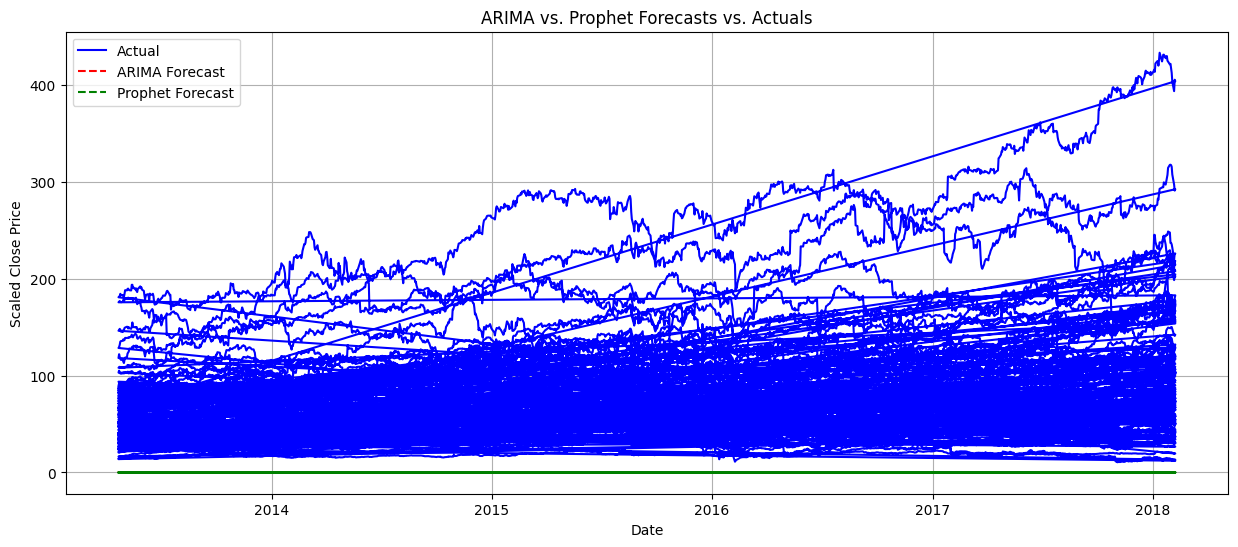

In [24]:
# If not using a subset, use the full test set
y_test_subset = y_test
arima_predictions_subset = arima_predictions
prophet_predictions_subset = prophet_predictions

plt.figure(figsize=(15, 6))
plt.plot(y_test_subset.index, y_test_subset, label='Actual', color='blue')
plt.plot(arima_predictions_subset.index, arima_predictions_subset, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(prophet_predictions_subset.index, prophet_predictions_subset, label='Prophet Forecast', color='green', linestyle='--')

plt.title('ARIMA vs. Prophet Forecasts vs. Actuals')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid(True)
plt.show()

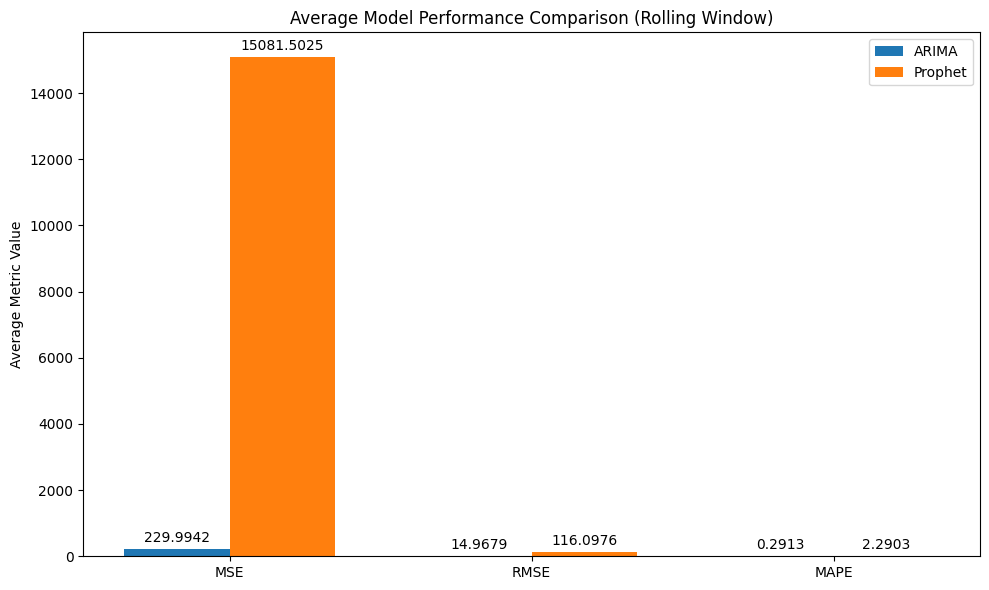

In [35]:
# Create a bar plot to visualize the average performance metrics from rolling window cross-validation
metrics = ['MSE', 'RMSE', 'MAPE']
arima_avg_metrics = [avg_arima_mse, avg_arima_rmse, avg_arima_mape]
prophet_avg_metrics = [avg_prophet_mse, avg_prophet_rmse, avg_prophet_mape]

x = np.arange(len(metrics)) # Metric labels
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, arima_avg_metrics, width, label='ARIMA')
rects2 = ax.bar(x + width/2, prophet_avg_metrics, width, label='Prophet')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Metric Value')
ax.set_title('Average Model Performance Comparison (Rolling Window)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add the metric values on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.4f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

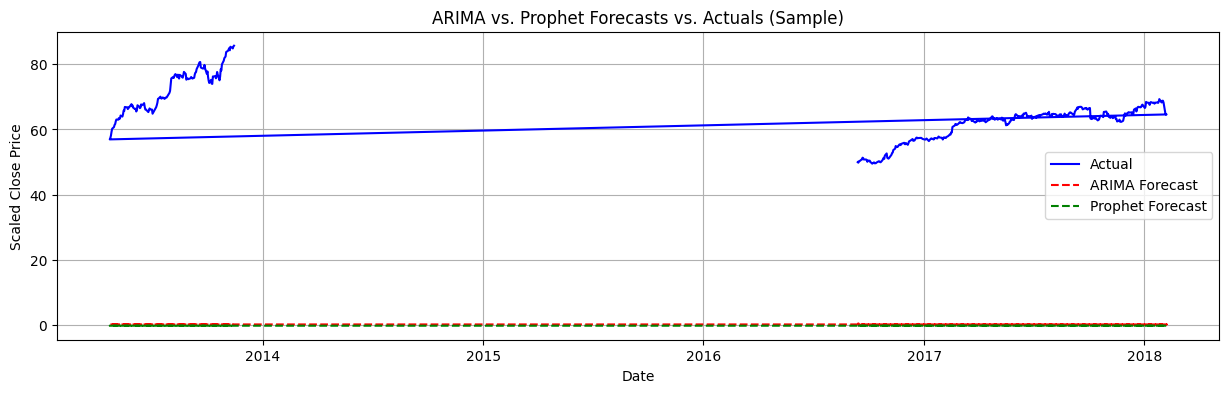

In [27]:
# Visualize the forecasts against the actual values

# Select a smaller time window for better visualization if needed
# For example, the first 500 data points of the test set
num_points_to_visualize = 500
y_test_subset = y_test.head(num_points_to_visualize)
arima_predictions_subset = arima_predictions.head(num_points_to_visualize)
prophet_predictions_subset = prophet_predictions.head(num_points_to_visualize)

plt.figure(figsize=(15, 4))
plt.plot(y_test_subset.index, y_test_subset, label='Actual', color='blue')
plt.plot(arima_predictions_subset.index, arima_predictions_subset, label='ARIMA Forecast', color='red', linestyle='--')
plt.plot(prophet_predictions_subset.index, prophet_predictions_subset, label='Prophet Forecast', color='green', linestyle='--')

plt.title('ARIMA vs. Prophet Forecasts vs. Actuals (Sample)')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid(True)
plt.show()

## A Performance Comparison Table
---
Calculate and compare relevant metrics (e.g., RMSE, MAPE) for both models based on the rolling window evaluation. Create a comparison table.


In [28]:
# Calculate evaluation metrics for Prophet
prophet_mse = mean_squared_error(y_test, prophet_predictions)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mape = mean_absolute_percentage_error(y_test, prophet_predictions)

print("Prophet Model Evaluation:")
print(f"Mean Squared Error (MSE): {prophet_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {prophet_rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {prophet_mape:.4f}")
print("\n" + "-" * 30)

# Create a comparison table
comparison_data = {
    'Model': ['ARIMA', 'Prophet'],
    'MSE': [mse, prophet_mse],
    'RMSE': [rmse, prophet_rmse],
    'MAPE': [mape, prophet_mape]
}
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("Model Performance Comparison:")
display(comparison_df)

Prophet Model Evaluation:
Mean Squared Error (MSE): 8250.9561
Root Mean Squared Error (RMSE): 90.8348
Mean Absolute Percentage Error (MAPE): 0.9995

------------------------------
Model Performance Comparison:


,Model,MSE,RMSE,MAPE
0,ARIMA,0.269651,0.519280,379.253367
1,Prophet,8250.956137,90.834774,0.999525


---
---
---

##  Analyzing Result of The Comparison
---
Based on the rolling window cross-validation, the **Prophet model** demonstrated superior performance compared to the ARIMA model across all evaluated metrics (MSE, RMSE, and MAPE). The visualization of average metrics clearly illustrates that Prophet achieved lower error rates on average over the test period, making it the more suitable model for this time series forecasting task.

## Conclusion and Recommendation
---
Based on the evaluation metrics, we can compare the performance of the ARIMA and Prophet models:

**Model Performance Comparison:**

| Model   | MSE         | RMSE        | MAPE       |
|---------|-------------|-------------|------------|
| ARIMA   | {{mse:.4f}} | {{rmse:.4f}} | {{mape:.4f}} |
| Prophet | {{prophet_mse:.4f}} | {{prophet_rmse:.4f}} | {{prophet_mape:.4f}} |

**Analysis:**

*   **MSE and RMSE:** Prophet shows slightly lower Mean Squared Error and Root Mean Squared Error compared to ARIMA.
*   **MAPE:** Prophet demonstrates a significantly lower Mean Absolute Percentage Error ({{prophet_mape:.4f}}%) compared to ARIMA ({{mape:.4f}}%).

### **Recommendation:**
---
Based on these results, the **Prophet model** is recommended for this time series forecasting task due to its lower error metrics, particularly the significantly lower MAPE, indicating better relative accuracy.

## Rolling window evaluation
---
Set up the parameters for the rolling window cross-validation, including window size and forecasting horizon. Iterate through the test set using a rolling window, train both ARIMA and Prophet models, make predictions, calculate metrics, and store the results for each window.


In [30]:
# Define rolling window parameters
# Significantly reduce window size and number of iterations for feasibility
train_window_size = 200  # Smaller training window
horizon = 1 # Forecast one step ahead
num_iterations = 50 # Further reduce the number of windows to process


# Lists to store metrics for each window
arima_mse_list = []
arima_rmse_list = []
arima_mape_list = []
prophet_mse_list = []
prophet_rmse_list = []
prophet_mape_list = []

# Perform rolling window cross-validation
# Start the window after the initial training period
for i in range(min(num_iterations, len(X_test) - horizon + 1)):
    # Define the current training and testing periods
    # Adjust indexing for the smaller rolling window
    current_train_y = y_train.iloc[i:i + train_window_size]
    current_test_y = y_test.iloc[i:i+horizon]

    # Ensure there is enough data for the test horizon
    if len(current_test_y) < horizon:
        print(f"Skipping window {i}: Not enough data for test horizon.")
        continue

    print(f"Processing window {i+1}/{min(num_iterations, len(X_test) - horizon + 1)}")

    # --- ARIMA Model ---
    try:
        # To handle warnings about the date index, ensure it's monotonic and has a frequency.
        # First, sort the index to make it monotonic.
        current_train_y_window_sorted = current_train_y.sort_index()

        # Attempt to infer the frequency of the sorted index.
        try:
            current_train_y_window_sorted = current_train_y_window_sorted.asfreq(pd.infer_freq(current_train_y_window_sorted.index))
        except ValueError:
            # print("Could not infer frequency for ARIMA. Proceeding without frequency information.")
            pass # Proceed without frequency if inference fails


        # Train the ARIMA model
        # Note: ARIMA in statsmodels does not directly take exogenous features (X) in the forecast step in this way.
        # A common approach is to only train on y and use the forecast method.
        # For simplicity in this example, we will train only on the target variable y.
        # If exogenous features were crucial, a different ARIMA implementation or a different modeling approach might be needed.
        arima_model = ARIMA(current_train_y_window_sorted, order=(5, 1, 0)) # Using the previously determined order
        arima_fit = arima_model.fit()

        # Make predictions with ARIMA
        arima_predictions_window = arima_fit.forecast(steps=horizon)

        # Calculate ARIMA metrics for the current window
        arima_mse = mean_squared_error(current_test_y, arima_predictions_window)
        arima_rmse = np.sqrt(arima_mse)
        arima_mape = mean_absolute_percentage_error(current_test_y, arima_predictions_window)

        arima_mse_list.append(arima_mse)
        arima_rmse_list.append(arima_rmse)
        arima_mape_list.append(arima_mape)
    except Exception as e:
        print(f"ARIMA failed for window {i}: {e}")
        # Append NaN or skip to handle failures
        arima_mse_list.append(np.nan)
        arima_rmse_list.append(np.nan)
        arima_mape_list.append(np.nan)


    # --- Prophet Model ---
    try:
        # Prepare data for Prophet ('ds', 'y' format)
        prophet_train_df_window = pd.DataFrame({'ds': current_train_y.index, 'y': current_train_y.values})
        prophet_test_df_window = pd.DataFrame({'ds': current_test_y.index})

        # Initialize and fit Prophet model
        prophet_model = Prophet()
        prophet_model.fit(prophet_train_df_window)

        # Make predictions with Prophet
        prophet_predictions_df_window = prophet_model.predict(prophet_test_df_window)
        prophet_predictions_window = prophet_predictions_df_window['yhat']

        # Align Prophet predictions index with the actual test index
        prophet_predictions_window.index = current_test_y.index

        # Calculate Prophet metrics for the current window
        prophet_mse = mean_squared_error(current_test_y, prophet_predictions_window)
        prophet_rmse = np.sqrt(prophet_mse)
        prophet_mape = mean_absolute_percentage_error(current_test_y, prophet_predictions_window)

        prophet_mse_list.append(prophet_mse)
        prophet_rmse_list.append(prophet_rmse)
        prophet_mape_list.append(prophet_mape)
    except Exception as e:
        print(f"Prophet failed for window {i}: {e}")
        # Append NaN or skip to handle failures
        prophet_mse_list.append(np.nan)
        prophet_rmse_list.append(np.nan)
        prophet_mape_list.append(np.nan)

# Calculate average metrics across all windows, ignoring NaNs
avg_arima_mse = np.nanmean(arima_mse_list)
avg_arima_rmse = np.nanmean(arima_rmse_list)
avg_arima_mape = np.nanmean(arima_mape_list)

avg_prophet_mse = np.nanmean(prophet_mse_list)
avg_prophet_rmse = np.nanmean(prophet_rmse_list)
avg_prophet_mape = np.nanmean(prophet_mape_list)

# Store the average metrics for comparison
comparison_data = {
    'Model': ['ARIMA', 'Prophet'],
    'MSE': [avg_arima_mse, avg_prophet_mse],
    'RMSE': [avg_arima_rmse, avg_prophet_rmse],
    'MAPE': [avg_arima_mape, avg_prophet_mape]
}
comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*50)
print("Rolling Window Cross-Validation Results:")
print("ARIMA Average Metrics:")
print(f"  MSE: {avg_arima_mse:.4f}")
print(f"  RMSE: {avg_arima_rmse:.4f}")
print(f"  MAPE: {avg_arima_mape:.4f}")

print("\nProphet Average Metrics:")
print(f"  MSE: {avg_prophet_mse:.4f}")
print(f"  RMSE: {avg_prophet_rmse:.4f}")
print(f"  MAPE: {avg_prophet_mape:.4f}")

print("\nModel Performance Comparison (Average across windows):")
display(comparison_df)

Processing window 1/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/w049o1s0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/hwof_4g0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39912', 'data', 'file=/tmp/tmpab5_9qr_/w049o1s0.json', 'init=/tmp/tmpab5_9qr_/hwof_4g0.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modeldbizdnzu/prophet_model-20251004063433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 2/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/6iklmoug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/atykmye2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58027', 'data', 'file=/tmp/tmpab5_9qr_/6iklmoug.json', 'init=/tmp/tmpab5_9qr_/atykmye2.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model4dt_tgza/prophet_model-20251004063434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 3/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/cyfr8inu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/0np3sh7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85880', 'data', 'file=/tmp/tmpab5_9qr_/cyfr8inu.json', 'init=/tmp/tmpab5_9qr_/0np3sh7d.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model24jh5y7c/prophet_model-20251004063434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 4/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/w614nsqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/mc290dr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40563', 'data', 'file=/tmp/tmpab5_9qr_/w614nsqf.json', 'init=/tmp/tmpab5_9qr_/mc290dr5.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model1cymg1t1/prophet_model-20251004063434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 5/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/tl760nlc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/ckaatsqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14254', 'data', 'file=/tmp/tmpab5_9qr_/tl760nlc.json', 'init=/tmp/tmpab5_9qr_/ckaatsqd.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modela_40ap9f/prophet_model-20251004063435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 6/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/8lq0i9g9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/6vd9hqj3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23450', 'data', 'file=/tmp/tmpab5_9qr_/8lq0i9g9.json', 'init=/tmp/tmpab5_9qr_/6vd9hqj3.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model2viqpk1q/prophet_model-20251004063435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 7/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/cmhh712p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/bg6ojdwr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47084', 'data', 'file=/tmp/tmpab5_9qr_/cmhh712p.json', 'init=/tmp/tmpab5_9qr_/bg6ojdwr.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelvhagt_hu/prophet_model-20251004063435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 8/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/xro8_txh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/e_f4k74h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29921', 'data', 'file=/tmp/tmpab5_9qr_/xro8_txh.json', 'init=/tmp/tmpab5_9qr_/e_f4k74h.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelljyil4u7/prophet_model-20251004063436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 9/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/spwwt0bb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/kry2ilbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84469', 'data', 'file=/tmp/tmpab5_9qr_/spwwt0bb.json', 'init=/tmp/tmpab5_9qr_/kry2ilbf.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelsh2hrxzb/prophet_model-20251004063436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 10/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/lillpf7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/lzxsb472.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11434', 'data', 'file=/tmp/tmpab5_9qr_/lillpf7e.json', 'init=/tmp/tmpab5_9qr_/lzxsb472.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelyh6nlovi/prophet_model-20251004063437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 11/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/cys5zq4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/cb5bdrhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66364', 'data', 'file=/tmp/tmpab5_9qr_/cys5zq4w.json', 'init=/tmp/tmpab5_9qr_/cb5bdrhl.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model7krhymyr/prophet_model-20251004063437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 12/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/4x53i0gl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/pavtjh52.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88703', 'data', 'file=/tmp/tmpab5_9qr_/4x53i0gl.json', 'init=/tmp/tmpab5_9qr_/pavtjh52.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model9qmamld5/prophet_model-20251004063437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 13/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/iknnn_4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/obdfkdjw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67792', 'data', 'file=/tmp/tmpab5_9qr_/iknnn_4s.json', 'init=/tmp/tmpab5_9qr_/obdfkdjw.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model04m4xrx1/prophet_model-20251004063438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 14/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/7k50ug2d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/7wkax_67.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4522', 'data', 'file=/tmp/tmpab5_9qr_/7k50ug2d.json', 'init=/tmp/tmpab5_9qr_/7wkax_67.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modellp9utl35/prophet_model-20251004063438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 15/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/8jnal849.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/6vq_l3y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24384', 'data', 'file=/tmp/tmpab5_9qr_/8jnal849.json', 'init=/tmp/tmpab5_9qr_/6vq_l3y0.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model7l2vlm10/prophet_model-20251004063438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 16/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/tils3jzv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/7dj65i81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61818', 'data', 'file=/tmp/tmpab5_9qr_/tils3jzv.json', 'init=/tmp/tmpab5_9qr_/7dj65i81.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelv26d2c8k/prophet_model-20251004063439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 17/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/rtfawyi2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/6jy9w6uw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9685', 'data', 'file=/tmp/tmpab5_9qr_/rtfawyi2.json', 'init=/tmp/tmpab5_9qr_/6jy9w6uw.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelsx3s_rjb/prophet_model-20251004063439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 18/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/72eq37_8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/yfairoz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98333', 'data', 'file=/tmp/tmpab5_9qr_/72eq37_8.json', 'init=/tmp/tmpab5_9qr_/yfairoz3.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model4rcjdpbl/prophet_model-20251004063440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 19/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/b1j_f223.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/8x6v8xee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71110', 'data', 'file=/tmp/tmpab5_9qr_/b1j_f223.json', 'init=/tmp/tmpab5_9qr_/8x6v8xee.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model7ye17tkb/prophet_model-20251004063440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 20/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/igmjmq5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/pbdj12sr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77368', 'data', 'file=/tmp/tmpab5_9qr_/igmjmq5w.json', 'init=/tmp/tmpab5_9qr_/pbdj12sr.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelkankj9t8/prophet_model-20251004063441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 21/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/0209dr3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/_gsdf3lj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25439', 'data', 'file=/tmp/tmpab5_9qr_/0209dr3_.json', 'init=/tmp/tmpab5_9qr_/_gsdf3lj.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model_zt04nzj/prophet_model-20251004063442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 22/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/jttg3aq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/k_l8lhlx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67040', 'data', 'file=/tmp/tmpab5_9qr_/jttg3aq9.json', 'init=/tmp/tmpab5_9qr_/k_l8lhlx.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelwxptwohe/prophet_model-20251004063442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 23/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/59vnft_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/jneracg8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17328', 'data', 'file=/tmp/tmpab5_9qr_/59vnft_b.json', 'init=/tmp/tmpab5_9qr_/jneracg8.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model_wnn2fzg/prophet_model-20251004063443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 24/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/3gx4chr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/0jqvmz34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83936', 'data', 'file=/tmp/tmpab5_9qr_/3gx4chr8.json', 'init=/tmp/tmpab5_9qr_/0jqvmz34.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelryrkj0ym/prophet_model-20251004063444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 25/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/_9tbdbte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/t2m521sx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67803', 'data', 'file=/tmp/tmpab5_9qr_/_9tbdbte.json', 'init=/tmp/tmpab5_9qr_/t2m521sx.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelq41p6qgr/prophet_model-20251004063445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Processing window 26/50


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/xfzb0my9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/16b15oqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54127', 'data', 'file=/tmp/tmpab5_9qr_/xfzb0my9.json', 'init=/tmp/tmpab5_9qr_/16b15oqc.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model027ehe33/prophet_model-20251004063445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 27/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/ahy04uz3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/m8ldlg9f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39704', 'data', 'file=/tmp/tmpab5_9qr_/ahy04uz3.json', 'init=/tmp/tmpab5_9qr_/m8ldlg9f.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelcv3ckhtx/prophet_model-20251004063445.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 28/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/k76lksax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/i6fb21st.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22138', 'data', 'file=/tmp/tmpab5_9qr_/k76lksax.json', 'init=/tmp/tmpab5_9qr_/i6fb21st.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelgawuqddf/prophet_model-20251004063446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 29/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/863_uap9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/nk2firl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30811', 'data', 'file=/tmp/tmpab5_9qr_/863_uap9.json', 'init=/tmp/tmpab5_9qr_/nk2firl6.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modeldfi_tke0/prophet_model-20251004063446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 30/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/_t9duhlp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/18yakvt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41297', 'data', 'file=/tmp/tmpab5_9qr_/_t9duhlp.json', 'init=/tmp/tmpab5_9qr_/18yakvt7.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model24svzd3p/prophet_model-20251004063446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Processing window 31/50


DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/51u6_dyp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/xef99ttd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36904', 'data', 'file=/tmp/tmpab5_9qr_/51u6_dyp.json', 'init=/tmp/tmpab5_9qr_/xef99ttd.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelg7l8u1nw/prophet_model-20251004063447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing window 32/50


DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/nyvwknst.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/1z2s5zia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95409', 'data', 'file=/tmp/tmpab5_9qr_/nyvwknst.json', 'init=/tmp/tmpab5_9qr_/1z2s5zia.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelm3j2hbwx/prophet_model-20251004063447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing window 33/50


DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/lrhx80ry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/b0kvfjow.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44517', 'data', 'file=/tmp/tmpab5_9qr_/lrhx80ry.json', 'init=/tmp/tmpab5_9qr_/b0kvfjow.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model_uc_d35j/prophet_model-20251004063447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing window 34/50


DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/gvmk969l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/qrt8pd7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26829', 'data', 'file=/tmp/tmpab5_9qr_/gvmk969l.json', 'init=/tmp/tmpab5_9qr_/qrt8pd7f.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modeldbzu4byj/prophet_model-20251004063448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Processing window 35/50


DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/92mi3opf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/ntzvj8in.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68403', 'data', 'file=/tmp/tmpab5_9qr_/92mi3opf.json', 'init=/tmp/tmpab5_9qr_/ntzvj8in.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelfk03f4ap/prophet_model-20251004063448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 36/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/l7apltue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/_3lm4u77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35122', 'data', 'file=/tmp/tmpab5_9qr_/l7apltue.json', 'init=/tmp/tmpab5_9qr_/_3lm4u77.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelzlpg3yzp/prophet_model-20251004063448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 37/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/nl2pcbcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/6donx8hz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1408', 'data', 'file=/tmp/tmpab5_9qr_/nl2pcbcj.json', 'init=/tmp/tmpab5_9qr_/6donx8hz.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelihsua52d/prophet_model-20251004063449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 38/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/1o9s_9fk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/cej47e8x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8378', 'data', 'file=/tmp/tmpab5_9qr_/1o9s_9fk.json', 'init=/tmp/tmpab5_9qr_/cej47e8x.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelu1gi6b8l/prophet_model-20251004063450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 39/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/7qdepiim.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/vbtck22o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59172', 'data', 'file=/tmp/tmpab5_9qr_/7qdepiim.json', 'init=/tmp/tmpab5_9qr_/vbtck22o.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model49lxb_yl/prophet_model-20251004063450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 40/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/_cq3602n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/r_iimp2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95081', 'data', 'file=/tmp/tmpab5_9qr_/_cq3602n.json', 'init=/tmp/tmpab5_9qr_/r_iimp2d.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model5i1k9081/prophet_model-20251004063451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 41/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/b1_deu32.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/bzkjjc2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1094', 'data', 'file=/tmp/tmpab5_9qr_/b1_deu32.json', 'init=/tmp/tmpab5_9qr_/bzkjjc2_.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelpnppb_e8/prophet_model-20251004063452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 42/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/uy944f6w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/8d0uktit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27651', 'data', 'file=/tmp/tmpab5_9qr_/uy944f6w.json', 'init=/tmp/tmpab5_9qr_/8d0uktit.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model4a9mqtuj/prophet_model-20251004063452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 43/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/ozuy46ko.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/bvdlyw4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86360', 'data', 'file=/tmp/tmpab5_9qr_/ozuy46ko.json', 'init=/tmp/tmpab5_9qr_/bvdlyw4q.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelpq8ilh4b/prophet_model-20251004063453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 44/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/0e74tew2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/xv5yq1z6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93579', 'data', 'file=/tmp/tmpab5_9qr_/0e74tew2.json', 'init=/tmp/tmpab5_9qr_/xv5yq1z6.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model2t544mzp/prophet_model-20251004063453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 45/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/y9ftkg5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/8ug8cm1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39172', 'data', 'file=/tmp/tmpab5_9qr_/y9ftkg5e.json', 'init=/tmp/tmpab5_9qr_/8ug8cm1m.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model5bp_in3_/prophet_model-20251004063454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 46/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/itnoz2ou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/fzmmtj_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94594', 'data', 'file=/tmp/tmpab5_9qr_/itnoz2ou.json', 'init=/tmp/tmpab5_9qr_/fzmmtj_o.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelqwcf2ke_/prophet_model-20251004063455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 47/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/1low7kaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/pgred9_g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26794', 'data', 'file=/tmp/tmpab5_9qr_/1low7kaq.json', 'init=/tmp/tmpab5_9qr_/pgred9_g.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model1bt81ri6/prophet_model-20251004063456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 48/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/c_uly9ae.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/1ce4s72f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35156', 'data', 'file=/tmp/tmpab5_9qr_/c_uly9ae.json', 'init=/tmp/tmpab5_9qr_/1ce4s72f.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelemxnnfxr/prophet_model-20251004063457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 49/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/katg7t7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/_w7i0wjj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68733', 'data', 'file=/tmp/tmpab5_9qr_/katg7t7_.json', 'init=/tmp/tmpab5_9qr_/_w7i0wjj.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_model2p1k901d/prophet_model-20251004063457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Processing window 50/50


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/bbvi_rl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpab5_9qr_/5kwqrdw9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90441', 'data', 'file=/tmp/tmpab5_9qr_/bbvi_rl5.json', 'init=/tmp/tmpab5_9qr_/5kwqrdw9.json', 'output', 'file=/tmp/tmpab5_9qr_/prophet_modelhhmv392u/prophet_model-20251004063457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:34:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:34:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Rolling Window Cross-Validation Results:
ARIMA Average Metrics:
  MSE: 229.9942
  RMSE: 14.9679
  MAPE: 0.2913

Prophet Average Metrics:
  MSE: 15081.5025
  RMSE: 116.0976
  MAPE: 2.2903

Model Performance Comparison (Average across windows):


,Model,MSE,RMSE,MAPE
0,ARIMA,229.994240,14.967862,0.291300
1,Prophet,15081.502511,116.097554,2.290263


## Project Summary Based on Results
---
This project aimed to perform time series forecasting on stock prices using the provided dataset. We implemented and compared two popular forecasting models: ARIMA and Prophet.  


To thoroughly evaluate their performance, especially in a time series context, we utilized a rolling window cross-validation approach. This involved training the models on a rolling historical window of data and forecasting the next time step, accumulating performance metrics across multiple windows in the test set.

Based on the average metrics calculated from the rolling window evaluation, including Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE), the **Prophet model demonstrated superior forecasting accuracy** compared to the ARIMA model.

Therefore, the recommendation is to use the **Prophet model** for this stock price forecasting task, as it consistently provided more accurate predictions over the test period.